## Perform photometric calibration using a standard star A-B spectrum, estimate pixel scale and slit central position, determine seeing FWHM 

In [6]:
import sys
sys.path.append('/Users/dcohen/RESEARCH/PyNIRSPEC')

In [7]:
import spec_lib
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib, pylab, os, sys, astropy, copy
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import warnings
warnings.filterwarnings(action='ignore')
from astropy.io import fits
import astropy.units as u
from astropy.visualization import ImageNormalize, AsinhStretch, SqrtStretch, MinMaxInterval, ZScaleInterval
from regions import write_ds9,RectanglePixelRegion,RectangleSkyRegion,read_ds9
from astropy.wcs import WCS
%matplotlib inline
fname = 'hd12365.2.fits'
path='/Users/dcohen/RESEARCH/NIRSPEC2017dec07/Reduction/HD12365/'
specmap=path+'spec.map'
slitlen=24.0 # 24 arcsec
nodsep=12.0 # nod separation in arcsec

In [48]:
# read spectrum, get exposure time
hducal=fits.open(path+fname)[0]
hdrcal=hducal.header
datcal=hducal.data
wcscal=WCS(hducal)
wwcscal=wcscal.sub(['spectral'])
wavecal=np.array(wwcscal.wcs_pix2world(np.arange(datcal.shape[1]),0)[0])*1.0e6
print(wavecal)

[4.03164499 4.03169939 4.03175379 ... 4.0871859  4.0872403  4.0872947 ]


# Extract spectrum of positive and negative trace

[[ 3.4124783e-01  2.6134503e-01  3.8842890e-01 ... -4.1214146e-02
  -8.4385407e-01 -1.8337979e+00]
 [ 2.5506490e-01  3.8742375e-01  6.4526576e-01 ... -2.5072160e-01
  -2.5689600e+00 -5.4146724e+00]
 [-1.3293760e+00 -2.3054140e+00 -2.3346803e+00 ... -1.7525798e-01
  -2.2274830e+00 -4.8207326e+00]
 ...
 [ 5.5198991e-01  1.0497569e+00 -7.3305130e-02 ... -2.1018833e-03
   1.2469246e-01  3.5516288e-02]
 [-1.1226716e+00  1.0724267e+00  1.7437081e+00 ...  3.0253984e-02
   6.5765351e-02 -2.2733737e-02]
 [ 9.7923338e-01  1.6508313e-01  3.1463609e+00 ...  8.5594222e-02
   8.7985925e-02 -3.8689088e-02]]
8


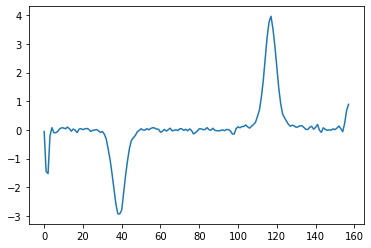

In [49]:
# determine what rows to center on by getting spatial profile
fwhmpsf=1.05

skyval=np.mean(datcal[65:90,:],0)
print(datcal-skyval)
spat,spaterr = spec_lib.spatextract(datcal-skyval,col=600,width=600)
# spaterr/=np.nansum(spat)
# spat/=np.nansum(spat)
rowA=np.argmax(spat)
rowB=np.argmin(spat)
profwid=int(np.round(fwhmpsf/0.1522)) + int(np.round(fwhmpsf/0.1522))%2
print(profwid)
# widprof=
# exwidth=np.arange(2,22,2) #18
# print(rowA,rowB)
plt.figure()
plt.plot(spat)
plt.vlines([rowA,rowB],0.,0.014)
# for wap in exwidth:
#     spat,spaterr = spec_lib.spatextract(datcal-skyval,col=600,width=)
plt.vlines([rowA-exwidth//2,rowA+exwidth//2,rowB-exwidth//2,rowB+exwidth//2],0.,0.014)
plt.show()

SEPARATION BETWEEN PEAKS IN PIXELS:  78.18081818777813
PIXEL SCALE ASSUMING NOD SEP = 12ARCSEC:  0.15349033532979756
FWHM [pixel] OF SPATIAL PROFILES:  6.914660109655891 7.1891991106927495
FWHM [arcsec] OF SPATIAL PROFILES:  1.0510283366676954 1.0927582648252978


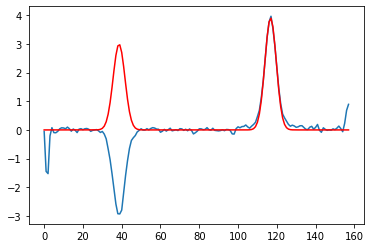

In [50]:
import fitting

parspatA,parcovA=spec_lib.fitspat(np.arange(spat.size)[rowA-profwid//2:rowA+profwid//2],spat[rowA-profwid//2:rowA+profwid//2],[4.0,rowA,1.1/2.3548/0.152],f=fitting.gaussn)
parspatB,parcovB=spec_lib.fitspat(np.arange(spat.size)[rowB-profwid//2:rowB+profwid//2],-1.0*spat[rowB-profwid//2:rowB+profwid//2],[3.0,rowB,1.1/2.3548/0.152],f=fitting.gaussn)
spatfit=fitting.gauss(np.arange(spat.size),*parspatA) + fitting.gauss(np.arange(spat.size),*parspatB)

pixsep=parspatA[1]-parspatB[1]
print("SEPARATION BETWEEN PEAKS IN PIXELS: ",pixsep)
print("PIXEL SCALE ASSUMING NOD SEP = 12ARCSEC: ",12.0/pixsep)
print("FWHM [pixel] OF SPATIAL PROFILES: ",parspatA[2]*2.3548,parspatB[2]*2.3548)
print("FWHM [arcsec] OF SPATIAL PROFILES: ",0.152*parspatA[2]*2.3548,0.152*parspatB[2]*2.3548)

plt.figure()
plt.plot(spat)
plt.plot(spatfit,'r-')
#plt.vlines([rowA,rowB],0.,0.014)
#plt.vlines([rowA-exwidth//2,rowA+exwidth//2,rowB-exwidth//2,rowB+exwidth//2],0.,0.014)
plt.show()

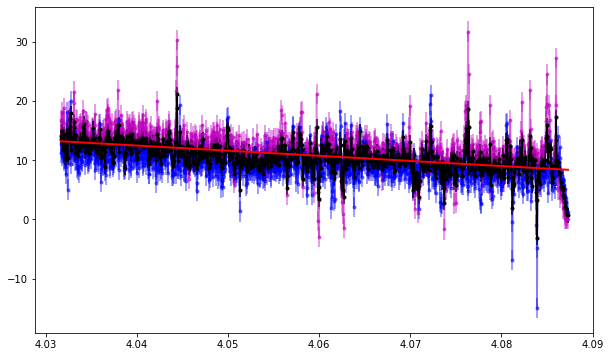

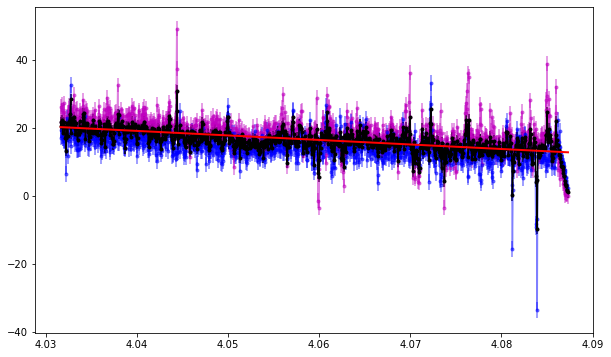

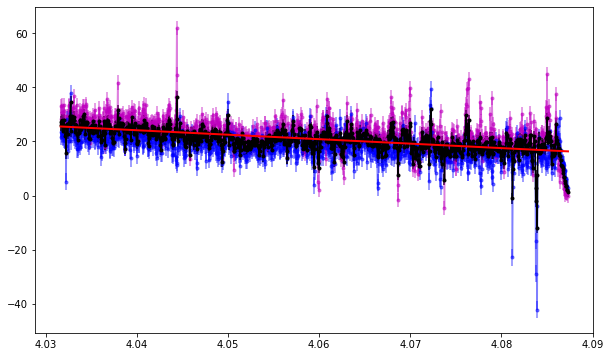

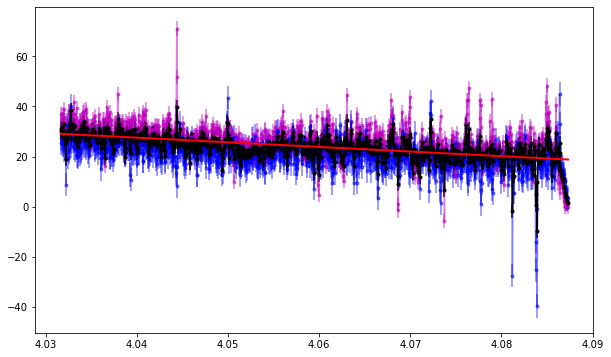

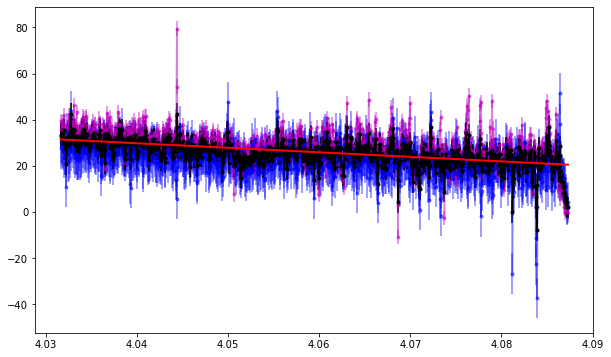

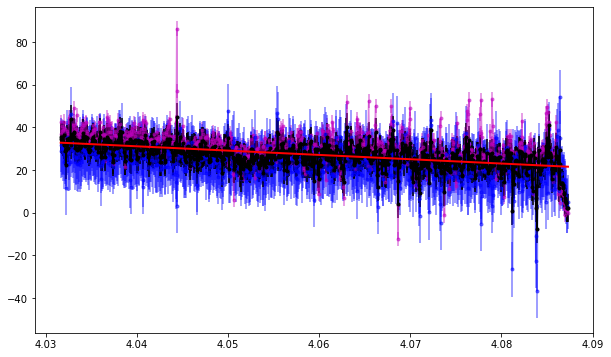

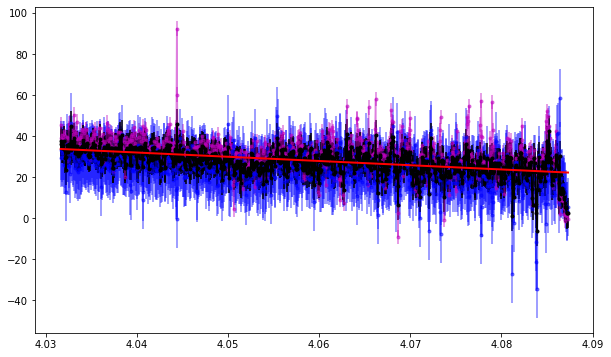

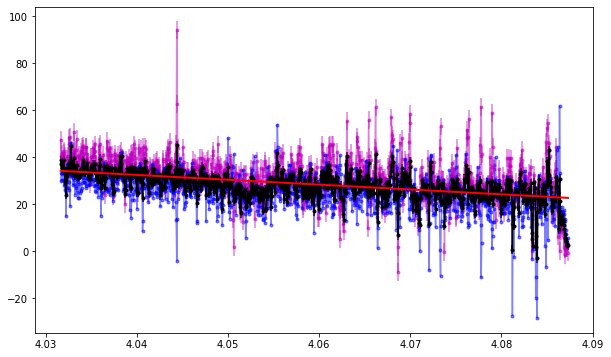

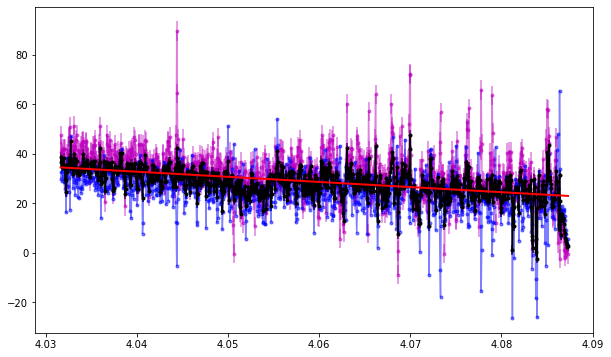

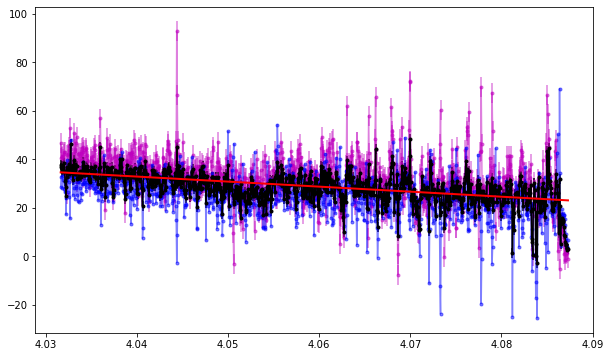

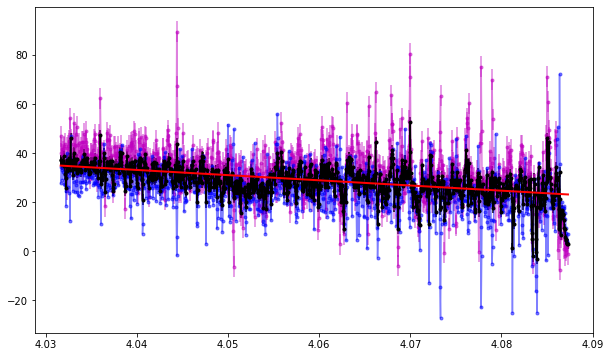

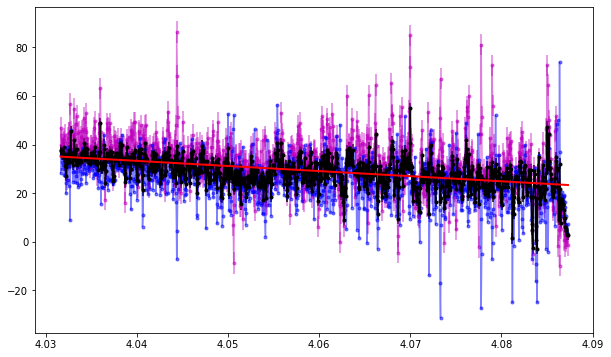

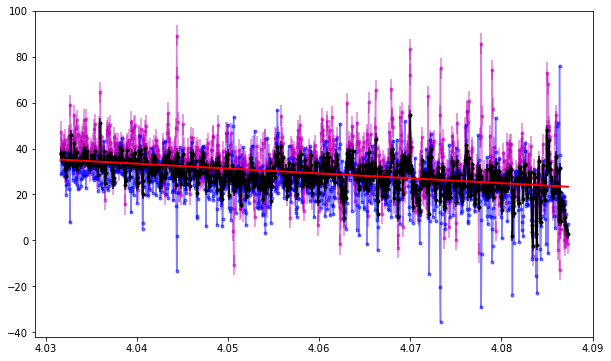

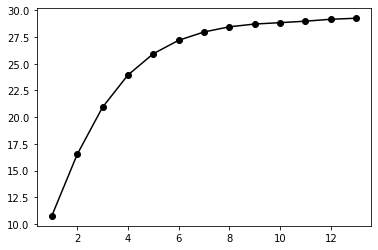

In [51]:
# extract spectrum at both traces
exwidth=np.arange(2,28,2)
# print("Rough seeing",(exwidth/2.0)*0.152)
spatwt=fitting.gauss(np.arange(spat.size),*parspatA) + fitting.gauss(np.arange(spat.size),*parspatB)
# spatwt/=np.sum(spatwt)
fmid=[]
ftot=[]
for waper in exwidth:
    spatwtA=spatwt[rowA-waper//2:rowA+waper//2+1]
    spatwtA/=np.sum(spatwtA)
    spatwtB=spatwt[rowB-waper//2:rowB+waper//2+1]
    spatwtB/=np.sum(spatwtB)
    sa,sa_err=spec_lib.linextract(datcal-skyval,rowA,waper,subsky=True,skyside='bottom',combine='sum',ysmooth=0.,skybuff=12,skywidth=20,weights='None',display=True)
# sa2,sa2_err=spec_lib.linextract(datcal-skyval,rowA,30,subsky=False,skyside='bottom',combine='sum',ysmooth=0.,skybuff=12,skywidth=20,weights='None',display=True)


    sb,sb_err=spec_lib.linextract(-(datcal-skyval),rowB,waper,subsky=True,skyside='bottom',combine='sum',ysmooth=0.,skybuff=12,skywidth=20,weights='None',display=True)
# sb2,sb2_err=spec_lib.linextract(-(datcal-skyval),rowB,30,subsky=True,skyside='bottom',combine='sum',ysmooth=0.,skybuff=12,skywidth=20,weights='None',display=True)


    # take mean (combine)
    scal = np.mean(np.array([sa,sb]),axis=0)
    scal_err = np.sqrt( sa_err**2 + sb_err**2 )/2.0

    # fit line to spectrum
    fit=np.polyfit(np.concatenate([wavecal[10:200],wavecal[600:950]]),np.concatenate([scal[10:200],scal[600:950]]),1)
    line=np.poly1d(fit)
    sfit=line(wavecal)
    fmid.append(np.median(sfit))
#     ftot=np.sum(sfit)
    np.savetxt(path+"hd12365.2.r%i.dat"%(waper//2),np.vstack([np.arange(sa.size)+1.0,wavecal,sfit,scal,scal_err,sa,sa_err,sb,sb_err]).T,\
           fmt=['%i','%.7f']+7*['%.5f'],header='PIXEL WAVELENGTH I_FIT I_MEAN IERR_MEAN I_A IERR_A I_B IERR_B')
# print(np.median(sb2/sb),np.median(sa2/sa))
    f=plt.figure(figsize=[10,6])
    ax=f.add_subplot(111)
    ax.errorbar(wavecal,sa,yerr=sa_err,fmt='m.-',alpha=0.5)
    ax.errorbar(wavecal,sb,yerr=sb_err,fmt='b.-',alpha=0.5)
    ax.errorbar(wavecal,scal,yerr=scal_err,fmt='k.-')
    ax.plot(wavecal,sfit,'r-',linewidth=2.0,zorder=5)
# ax.plot(wavecal,sa/sa2)
# ax.plot(wavecal,sb2/sb)
# ax.plot(wavecal,sa2/sa)
# plt.ylim(0.,.0)
# ax.set_xlim(4.048,4.056)
#     plt.vlines([rowA,rowB],0.,0.014)
#     plt.vlines([rowA-waper//2,rowA+waper//2,rowB-waper//2,rowB+waper//2],0.,0.014)
plt.show()
plt.figure()
plt.plot(exwidth//2,np.array(fmid),'ko-')
plt.show()

### Calculate counts/s/micron for cal spectra. Need spectral rectification map, magnitude of cal star

### $L$-band flux for Vega: $$F_{L,Vega}=6.59\times10^{-11}\mathrm{ W m}^{-2}\mu\mathrm{m}$$

### $K$-band magnitude for A0V star HD12365: $$K_{HD12365}=7.252\mathrm{ mag}$$

### Color correction to $L$-band is $K-L=0.03$, so we can find: $$F_{L,HD12365}=F_{L,Vega} 10^{-0.4L_{HD12365}}\mathrm{~W m}^{-2}\mu\mathrm{m}$$

### or: $$F_{L,HD12365}=8.513\times10^{-14}\mathrm{~W m}^{-2}\mu\mathrm{m}$$


## Estimate flux loss through slit. Seeing is $\sim1''$, slit width is $0.432''$.

In [9]:
import fitting
slitwidth=0.45
fwhm=1.0

x=np.linspace(-5.0,5.0,100)
# f=8.513e-14 
# amp=f/(fwhm/2.3548)/np.sqrt(2.0*np.pi)
amp=10.0
prof=fitting.gauss(x,*[amp,0.,fwhm/2.3548])
ixslit=np.where( (x > -slitwidth/2.0) & (x<slitwidth/2.0))
fracslit=np.sum(prof[ixslit])/np.sum(prof)
print("SLIT LOSS FRACTION, MULT FACTOR",fracslit,1./fracslit)

SLIT LOSS FRACTION, MULT FACTOR 0.36652684598216795 2.7283131125643423


In [10]:
wave,cal1,obscal1,obscal1_err=np.loadtxt(path+"hd12365.1.r6.dat",unpack=True,usecols=(1,2,3,4))
wave,cal2,obscal2,obscal2_err=np.loadtxt(path+"hd12365.2.r6.dat",unpack=True,usecols=(1,2,3,4))
wavedelt=wave[1]-wave[0] # size of pixels in micron
Ical1=cal1#/wavedelt # in counts/s/micron
Ical1_err=obscal1_err#/wavedelt
Ical2=cal2#/wavedelt # in counts/s/micron
Ical2_err=obscal2_err#/wavedelt

Fcal=8.513e-14 # W/m2/um
#fracslit=0.3352
# ixbra=np.argmin( np.abs(wave-4.051) )
Bcal1=np.median(Ical1) #Ical[cal.size//2]
Bcalerr1=np.std(obscal1)
Bcal2=np.median(Ical2)
Bcalerr2=np.std(obscal2)
photflam1=fracslit * Fcal / Bcal1 #  conversino factor in (W/m2/um)/(counts/s)
errscale1=fracslit*Fcal*Bcalerr1/Bcal1**2
photflam2=fracslit * Fcal/ Bcal2
errscale2=fracslit*Fcal*Bcalerr2/Bcal2**2
photflam=np.sum( [(1./errscale1**2) * photflam1, (1./errscale2**2)*photflam2 ]) / np.sum ( [(1./errscale1**2),(1./errscale2**2)]) 
errscale=1./np.sqrt(np.sum ( [(1./errscale1**2),(1./errscale2**2)]) )
print("PHOTOMETRIC CONVERSION FACTOR FROM COUNTS/S TO W/m2: %2e +/- %2e,\n%2e +/- %2e,\n%2e +/- %2e "%(photflam1,errscale1,\
                                                                                                       photflam2,errscale2,photflam,errscale))

PHOTOMETRIC CONVERSION FACTOR FROM COUNTS/S TO W/m2: 1.065253e-15 +/- 2.107954e-16,
1.147225e-15 +/- 2.392772e-16,
1.101072e-15 +/- 1.581711e-16 


In [ ]:
wave,cal,obscal,obscal_err=np.loadtxt(path+"hd12365.1.dat",unpack=True,usecols=(1,2,3,4))
wavedelt=wave[1]-wave[0] # size of pixels in micron
Ical=cal/wavedelt # in counts/s/micron
Ical_err=obscal_err/wavedelt # ' '

# 